In [1]:
import pandas as pd
import tensorflow as tf

# Load the dataset CSV
df = pd.read_csv('/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/label/final_data_label.csv')
train_df = df[df['usage'] == 'train']
val_df = df[df['usage'] == 'validate']

drop_index = train_df[train_df['filename'] == 'image_00006_Debris_2021.jpg'].index.tolist()
train_df.drop(drop_index, axis = 0, inplace=True)

train_df = train_df.sample(frac=1, random_state = 42).reset_index(drop=True) 
val_df = val_df.sample(frac=1, random_state = 42).reset_index(drop=True) 

# Convert filenames and labels into lists for TensorFlow Dataset
train_image_paths = ['/Users/nithish/Documents/Academics/Spring 24/AML/project/data/preprocessedFinal_data/train/' + fname for fname in train_df['filename']]
train_labels = train_df['class'].tolist()

val_image_paths = ['/Users/nithish/Documents/Academics/Spring 24/AML/project/data/preprocessedFinal_data/validate/' + fname for fname in val_df['filename']]
val_labels = val_df['class'].tolist()


# train_df['class']

/Users/nithish/Documents/Academics/Spring 24/AML/project/Venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/var/folders/nz/x14sy1sd2rj_6ltfxbm014780000gn/T/ipykernel_5204/3998627058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(drop_index, axis = 0, inplace=True)


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
IMG_SIZE = (128, 128)  # Define the image size

def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalize to [0, 1]
    return img

def load_and_preprocess(image_path, label):
    return preprocess_image(image_path), label

def create_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    return dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Create training and validation datasets
train_ds = create_dataset(train_image_paths, train_labels)
val_ds = create_dataset(val_image_paths, val_labels)


2024-04-20 17:26:35.978520: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-04-20 17:26:35.978559: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-20 17:26:35.978565: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-20 17:26:35.978588: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-20 17:26:35.978605: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
from tensorflow.keras import regularizers

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # # tf.keras.layers.BatchNormalization(),
    # Add a dropout layer to reduce overfitting
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    # Add L2 regularization to the dense layer
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    tf.keras.layers.Dropout(0.5), # Additional dropout layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set a custom learning rate for the Adam optimizer
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])


/Users/nithish/Documents/Academics/Spring 24/AML/project/Venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [4]:
history = model.fit(
    train_ds,
    epochs=29,
    validation_data=val_ds
)


Epoch 1/29


2024-04-20 17:26:36.638992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


657/657 ━━━━━━━━━━━━━━━━━━━━ 37s 54ms/step - accuracy: 0.6632 - loss: 1.0302 - val_accuracy: 0.7298 - val_loss: 0.5790
Epoch 2/29
657/657 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step - accuracy: 0.7536 - loss: 0.5424 - val_accuracy: 0.7446 - val_loss: 0.5374
Epoch 3/29
657/657 ━━━━━━━━━━━━━━━━━━━━ 36s 55ms/step - accuracy: 0.7943 - loss: 0.4808 - val_accuracy: 0.7654 - val_loss: 0.5050
Epoch 4/29
657/657 ━━━━━━━━━━━━━━━━━━━━ 37s 56ms/step - accuracy: 0.8215 - loss: 0.4407 - val_accuracy: 0.7750 - val_loss: 0.4947
Epoch 5/29
657/657 ━━━━━━━━━━━━━━━━━━━━ 38s 57ms/step - accuracy: 0.8357 - loss: 0.4105 - val_accuracy: 0.8045 - val_loss: 0.4537
Epoch 6/29
657/657 ━━━━━━━━━━━━━━━━━━━━ 37s 56ms/step - accuracy: 0.8489 - loss: 0.3895 - val_accuracy: 0.8154 - val_loss: 0.4351
Epoch 7/29
657/657 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - accuracy: 0.8569 - loss: 0.3729 - val_accuracy: 0.8194 - val_loss: 0.4298
Epoch 8/29
657/657 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - accuracy: 0.8684 - loss: 0.3593 - val_accurac

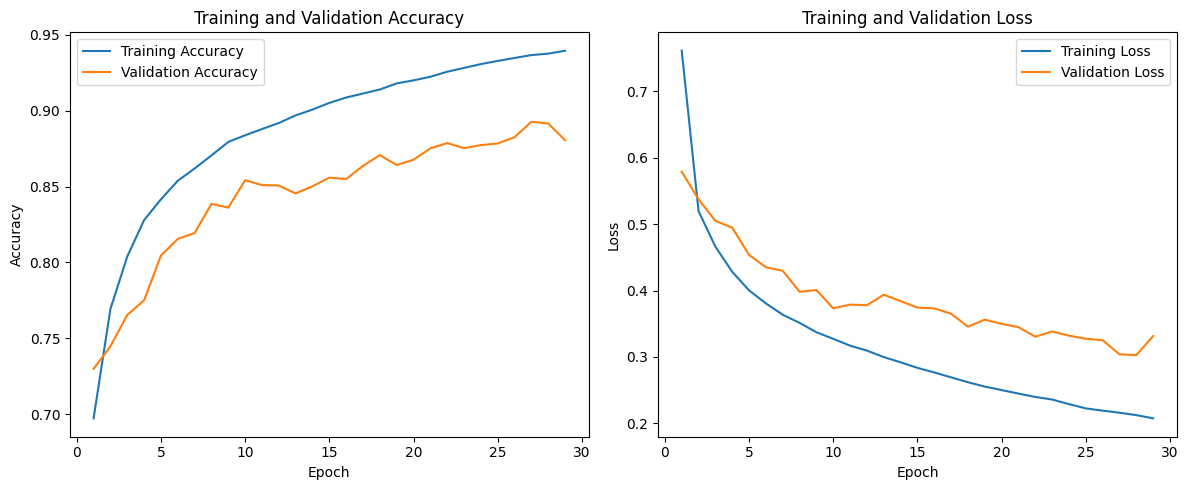

In [8]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Accuracy plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function with your model's history
plot_training_history(history)


In [9]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE
# BATCH_SIZE = 64
# IMG_SIZE = (128, 128)  # Define the image size

# def preprocess_image(image_path):
#     img = tf.io.read_file(image_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, IMG_SIZE)
#     img = img / 255.0  # Normalize to [0, 1]
#     return img

# def load_and_preprocess(image_path, label):
#     return preprocess_image(image_path), label

# def create_dataset(image_paths, labels):
#     dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
#     dataset = dataset.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
#     return dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# # Create training and validation datasets
# train_ds = create_dataset(train_image_paths, train_labels)
# val_ds = create_dataset(val_image_paths, val_labels)


In [10]:
# from tensorflow.keras import regularizers

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     # tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     # tf.keras.layers.BatchNormalization(),
#     # Add a dropout layer to reduce overfitting
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Flatten(),
#     # Add L2 regularization to the dense layer
#     tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
#     tf.keras.layers.Dropout(0.5), # Additional dropout layer
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# # Set a custom learning rate for the Adam optimizer
# adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

# model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])


In [11]:
model.save('final_CNN_model.h5')

In [13]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the model
model = load_model('final_CNN_model.h5')
model.summary()  # Optional: to verify that model is loaded correctly

# Define the image path
img_path = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/test/image_00036_2021.jpg'

# Load the image and preprocess it
img = image.load_img(img_path, target_size=(128, 128))  # Resize the image to match the model's expected input
img_array = image.img_to_array(img)  # Convert to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Create a batch
img_array /= 255.0  # Normalize to [0,1]

# Predict
predictions = model.predict(img_array)
predicted_class = (predictions > 0.5).astype(int)  # Use 0.5 as the threshold for binary classification

# Output the prediction
print("Predicted class:", predicted_class[0][0], "; Probability:", predictions[0][0])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,771 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
Predicted class: 1 ; Probability: 0.999998
